<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Final Delivery</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201506219 - [up201506219@fe.up.pt](mailto:up201506219@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/>

---

# IART

* [GitHub repository](https://github.com/msramalho/iart)
* [UCI source page](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29)
* [README](dataset/README.ipynb) of the dataset
* [Dataset file](dataset/frogs.csv)
* [Automatic Classification of Anuran Sounds Using Convolutional Neural Networks](report_material/papers/Automatic%20Classification%20of%20Anuran%20Sounds%20Using.pdf)
* [Tensorflow tutorial](https://www.tensorflow.org/get_started/premade_estimators)

# Code

## Initialization

### Import modules

In [36]:
import pandas as pd
import tensorflow as tf
import numpy as np
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling
import matplotlib.pyplot as plt # to display plots
from sklearn.model_selection import KFold, StratifiedKFold # for cross-validation, needs scipy
np.seterr(divide='ignore', invalid='ignore'); # avoid unnecessary messages

### Initialize constants

In [37]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
N_FEATURES   = 22 # the number of features in the dataset
LABEL_INDEX  = 24 # the index in the dataset where the label to predict is
BATCH_SIZE   = 100 # batch size for the train, evaluation and prediction
NUM_CLASSES  = 10 # last layer, num classifications
NUM_ITEMS    = 7195 #Num items in dataset
CROSS_VALIDATION_FUNCTION = StratifiedKFold # use KFold to ignore class representation

## Helper Functions

In this section we include functions that are directed at helping the visualisation of the project, the manipulation of data and the creation, training and evaluation of models. Here functions that start with an underscore (_) are purely 'private' helper functions and shouldn't be used or even considered for the evaluation of the report

### Chart Drawing and Visualization functions

In [38]:
from IPython.core.display import display_html, HTML
# function to print string into visual HTML
def html(s, html_tag=None):
    if html_tag:
        s = tag(html_tag, s)
    display_html(HTML(s))
def tag(tag, s):
    return "<%s>%s</%s>" % (tag, s, tag)

In [39]:
from IPython.display import display
# receives paddings and a list @layer_sizes with the number of nodes to draw
def _draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
# helper function to draw a neural network
def drawNN(hidden_layers, figsize=(12, 12), name=None):
    #plt.ioff() #plt.ion()
    plt.tight_layout()
    fig = plt.figure(figsize=figsize);
    ax = fig.gca()
    ax.axis('off')
    _draw_neural_net(ax, .1, .9, .1, .9, [N_FEATURES] + hidden_layers + [NUM_CLASSES])
    display(fig);
    plt.close();

In [40]:
# create an abstract histogram
def _draw_label_distribution(label_column, title_text):
    label_count = pd.Series.value_counts(label_column, normalize=True, sort=False)
    label_count = label_count.sort_index()
    label_count.plot(kind='barh', title=title_text, stacked=True, fontsize=15, figsize=(8,8), color="darkblue" )

# create a histogram with the distribution of species
def draw_species_distribution_chart(df, title_text="Species Dataset Distribution"):
    species_column = df['Species']
    _draw_label_distribution(species_column, title_text)

### Creating Deep Neural Network Models 
 * `my_feature_columns`        - the features that the model should receive as input
 * `inner_layers_architecture` - a list of N hidden layers where N[i] is the number of nodes of the layer i

In [41]:
def create_DNN(my_feature_columns, inner_layers_architecture, save_folder_path=None, num_classes=NUM_CLASSES):
    # Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
    classifier = tf.estimator.DNNClassifier(
            feature_columns = my_feature_columns,
            hidden_units = inner_layers_architecture, # 1:-1 removes the first and last elements of the architecture
            n_classes = num_classes, # num nodes of final layer
            model_dir = save_folder_path) # value None means it will be saved in temp, 
                                            # no need to generate path for each iteration
    return classifier

### Training Models

In [42]:
SHUFFLE_PARAM = NUM_ITEMS * 10 #df.shape[0] * 10
# helper function to yield a part of the training data to be used by TF's classifier.train method
def _train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(SHUFFLE_PARAM).repeat().batch(BATCH_SIZE)

In [43]:
# Train a model, given the train data and the number of steps
def train_model(classifier, train_x, numeric_train_y, num_steps=1000):
    classifier.train(input_fn=lambda:_train_input_fn(train_x, numeric_train_y), steps=num_steps)

### Evaluating Models

In [44]:
# helper function for the classifier.evaluate method
def _eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [45]:
# Evaluate a model - returns a tuple (eval_results, global_step)
def evaluate_model(classifier, test_x, numeric_test_y):
    return classifier.evaluate(input_fn=lambda:_eval_input_fn(dict(test_x), numeric_test_y))

In [46]:
# predict from a trained model - returns a list of the predictions
def predict_model(classifier, predict_x):
    predictions = list(classifier.predict(input_fn=lambda:_eval_input_fn(dict(predict_x))))
    return [el["class_ids"][0] for el in predictions]

### Dataset Splitting

In [47]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def _convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return [unique_labels.index(l) for l in labels]

In [48]:
def _format_TF_data(train, test):
    # split dataframes into X (features) and y (classes) - use species as label
    train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    
    # for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
    numeric_train_y = _convert_labels_to_number(train_y.iloc[:,0])
    numeric_test_y  = _convert_labels_to_number(test_y.iloc[:,0])
    
    return (train_x, numeric_train_y, test_x, numeric_test_y)

In [49]:
# Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
def get_TF_feature_columns(df):
    data_df = df.iloc[:,:N_FEATURES]
    return [tf.feature_column.numeric_column(key=key) for key in list(data_df)]

#### Simple data splitting into Train and Test data

In [50]:
# returns a single iteration
def simple_data_split_generator(df, labels, train_fraction):
    train=df.sample(frac=train_fraction, random_state=int(time.time()))
    test=df.drop(train.index)
    yield _format_TF_data(train, test) # in a for loop gives one single loop

#### Cross Validation splitting into Train and Test data

In [51]:
def _split_data_by_indices(train_indices, test_indices):
    train = df.iloc[train_indices]
    test = df.iloc[test_indices]
    return _format_TF_data(train, test)

In [52]:
def _get_k_fold_CV_split_indices(df, labels, num_folds = 3):
    k_fold = CROSS_VALIDATION_FUNCTION(n_splits = num_folds, shuffle=True)
    return k_fold.split(df, labels)

In [53]:
def kFoldCV_tf_data_generator(df, labels, train_fraction):
    num_folds = int(1.0 / (1.0 - train_fraction))
    for train_indices, test_indices in _get_k_fold_CV_split_indices(df, labels, num_folds):
        yield(_split_data_by_indices(train_indices, test_indices))

### Hyper-Parameter Tuning
Given a dataset, the respective labels, a function to split the data and another to calculate the number of steps, this function iterates over all the defined architectures in **INNER_LAYERS** and over all the **NUM_STEPS** and over all the  **TRAIN_FRACTIONS** and does the following:
 * Split the data accordingly
 * Train the model
 * Evaluate the model
 * Report the results
 
This can be used for quick comparison of multiple combinations of architectures, number of steps and train fractions, essentially tuning **hyper-parameters**. More can hyper-parameters can be added if needed.

In [54]:
def run_model_iterations(df, labels, data_generator, num_steps_calculator):
    evaluations = []
    for inner_architecture in INNER_LAYERS:
        #drawNN([N_FEATURES] + inner_architecture + [NUM_CLASSES])
        for num_total_steps in NUM_STEPS:
            for train_fraction in TRAIN_FRACTIONS:
                my_feature_columns = get_TF_feature_columns(df) # seems to need to generate one for each estimator
                classifier = create_DNN(my_feature_columns, inner_architecture)
                num_steps = num_steps_calculator(num_total_steps, train_fraction)
                for (train_x, numeric_train_y, test_x, numeric_test_y) in data_generator(df, labels, train_fraction):
                    train_model(classifier, train_x, numeric_train_y, num_steps)
                    eval_result = evaluate_model(classifier, test_x, numeric_test_y)
                    predictions = predict_model(classifier, test_x)
                # evaluation results
                evaluations.append({"config": (inner_architecture, train_fraction, num_total_steps), "eval_result" : eval_result, "prediction": (np.array(predictions), np.array(numeric_test_y))})
    html("Model iterations complete", "h1")
    return evaluations # evaluations can have duplicate 'keys' if k-fold is used

## Evaluation Metrics Used

From the confusion matrix, we derive the number of **true positives** (`TP`), **false positives** (`FP`), **true negatives** (`TN`) and **false negatives** (`FN`).

<img src="report_material/images/multiclass_confusion.png" width="300px" />
<p style="text-align:center">Image of a confusion matrix for a multiclass classification problem</p>

$ precision = \frac{ TP}{TP + FP} $

$ recall  = \frac{TP}{TP + FN} $

$ accuracy = \frac{TP + TN}{TP + FP + FN + TN} $

$ F1-score = 2 \cdot \frac{precision\cdot recall}{precision+ recall} $

Further metrics such as **specificity**, **negative predictive value**, **false positive rate**, **false negative rate** and **false discovery rate** were also calculated, but were not considered when making model decisions

In [55]:
# calculate metrics based on confusion matrix -> precision, recall, f1, ...
def print_metrics(prediction, confusion_matrix):
    predicted, actual = prediction
    
    # get values from confusion matrix for each class
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # false positives
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix) # false negatives
    TP = np.diag(confusion_matrix)  # true positives
    TN = confusion_matrix.sum() - (FP + FN + TP) # true negatives

    # calculate metrics
    TPR = TP/(TP+FN) # Recall, sensitivity, hit rate, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1  =  2 * ((PPV * TPR) / (PPV + TPR)) # f1-score
    ACC = (TP+TN)/(TP+FP+FN+TN) # accuracy
    
    #overall values in percentage
    metrics = tuple(map(lambda v: np.nanmean(v) * 100, [ACC, PPV, TPR, F1]))
    
    # create the table with the statistics
    header = tag("tr", "<th>Species</th><th>Accuracy</th> <th>Precision</th> <th>Recall</th> <th>F1-score</th>")
    body = ""
    footer = tag("tr", "<th>Average</th><th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th>" % metrics)
    for i in range(len(TP)):
        body += tag("tr", "<td>%s</td><td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td>" % (i, ACC[i] * 100, PPV[i] * 100, TPR[i] * 100, F1[i] * 100))
        
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;'>%s%s%s</table>" % (header, body, footer)
    html(table)
    return metrics

In [56]:
# print a confusion matrix after a prediction
def get_confusion_matrix(prediction):
    predicted, actual = prediction
    con_mat = tf.confusion_matrix(actual, predicted, num_classes=NUM_CLASSES)
    with tf.Session():
        return tf.Tensor.eval(con_mat,feed_dict=None, session=None)

### Functions to display and describe the output of a model

In [57]:
def print_configs(configs):
    header = tag("tr", "<th>Hidden Layers</th><th>Training Fraction</th> <th>Number of Steps</th>")
    body = tag("tr", "<th>%s</th><th>%.0f%%</th><th>%s</th>" % (configs[0], configs[1] * 100, configs[2]))
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;text-align=center'>%s%s</table>" % (header, body)
    html(table)

In [58]:
def display_model_results(evaluations):
    # show results, statistics
    print('Num Results: %d' % len(evaluations))
    chart_data = [] # data to create charts later
    for i, e in enumerate(evaluations):
        confusion_matrix = get_confusion_matrix(e["prediction"])
        html("<h2 style='text-align:center'>Iteration %d</h2>" % (i+1))
        
        print_configs(e["config"])
        drawNN(e["config"][0], (7,7))
        
        html("Confusion Matrix:", "h4")
        html("<br/>")
        print(confusion_matrix)
        
        metrics = print_metrics(e["prediction"], confusion_matrix)
        
        html("<hr>")
        
        chart_data.append((e["config"], metrics)) # config, [ACC, PPV, TPR, F1]
    display_model_comparison(chart_data)

In [59]:
# compare different architectures, train ratios and number of steps
def display_model_comparison(chart_data):
#     print(chart_data)
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 16})

    for layers in INNER_LAYERS:
        x, y = [], []
        for data in chart_data:
            if data[0][0] == layers:
                x.append(data[0][2])
                y.append(data[1][0])
        plt.plot(x, y, '-', label="%s layers" % layers)
        
    
    for steps in NUM_STEPS:
        y = []
        for data in chart_data:
            if data[0][2] == steps:
                y.append(data[1][0])
        plt.plot([steps] * len(y), y, 'x', label="%4d steps"%steps, markersize=16)
        
    plt.legend(loc='best')
    plt.show()

# Main

### Loading Data

In [60]:
# from csv to pandas Dataframe
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF

print("Got %d examples from the .csv" % df.shape[0])
df.head()

Got 7195 examples from the .csv


,MFCCs_1,MFCCs_2,MFCCs_3,MFCCs_4,MFCCs_5,MFCCs_6,MFCCs_7,MFCCs_8,MFCCs_9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [61]:
# get a mapping of all the labels in the Dataset into its integer values (required for Stratified Cross Validation)
labels = _convert_labels_to_number(df.iloc[:,LABEL_INDEX:LABEL_INDEX+1].iloc[:,0])

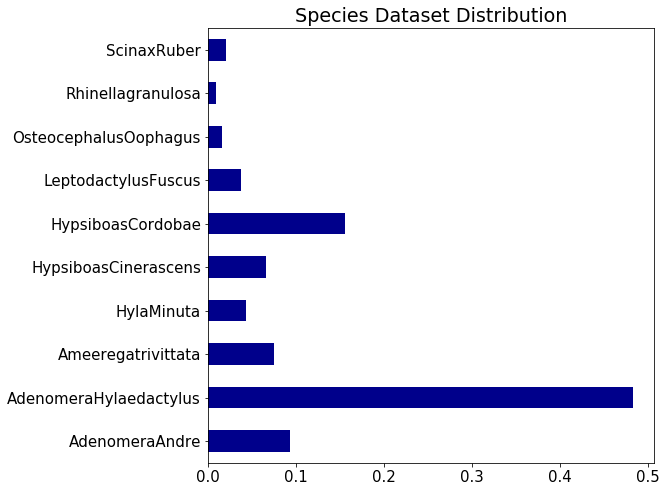

In [62]:
# draw dataset distribution
draw_species_distribution_chart(df)

### Running iterations

In [63]:
### Iterations

# modify here to set model configurations
INNER_LAYERS = [
    [10],
    [100],
    [10, 10],
    #[40, 40],
    #[10, 10, 10]
]

TRAIN_FRACTIONS = [
    0.8,
#     0.5,
]

NUM_STEPS = [
    100, 
    500,
#     1000
]

### Initial approach to dataset splitting
Random split into train and test

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [64]:
# this may take a while
steps_calc = lambda num_steps, train_fraction: num_steps
evaluations = run_model_iterations(df, labels, simple_data_split_generator, steps_calc)    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Ross\\AppData\\Local\\Temp\\tmp5vkvhghm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EB205670B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Ross\AppData\Local\Temp\tmp5vkvhghm\m

INFO:tensorflow:global_step/sec: 247.87
INFO:tensorflow:loss = 15.967631, step = 300 (0.403 sec)
INFO:tensorflow:global_step/sec: 272.954
INFO:tensorflow:loss = 12.588625, step = 400 (0.366 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\Ross\AppData\Local\Temp\tmp3xlfmln5\model.ckpt.
INFO:tensorflow:Loss for final step: 4.7148304.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-14:38:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmp3xlfmln5\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-14:38:30
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.97011817, average_loss = 0.12050454, global_step = 500, loss = 11.560403
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was final

Model iterations complete

Num Results: 6


Iteration 1

Hidden Layers,Training Fraction,Number of Steps
[10],80%,100


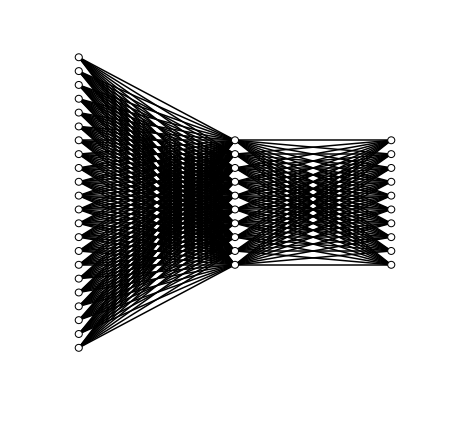

Confusion Matrix:

[[  0   8   0  30  18   0   0   0   0  15]
 [  0 219   2   0   0   0   0   0   2   3]
 [  0   3  97   2   0   0   0   0   0   0]
 [  0   0   1 122   7   0   0   0   1   0]
 [  0   1   0   7  87   0   0   0   0   0]
 [  0  15   1   1   2   0   0   0   0  12]
 [  0  18   4   0   0   0   0   0   1   0]
 [  0  14   0   0   1   0   0   0   0   0]
 [  0  36   2   5   0   0   0   0  19   0]
 [  0   2   0   0   0   0   0   0   0 681]]


Species,Accuracy,Precision,Recall,F1-score
0,95.07%,nan%,0.00%,nan%
1,92.77%,69.30%,96.90%,80.81%
2,98.96%,90.65%,95.10%,92.82%
3,96.25%,73.05%,93.13%,81.88%
4,97.50%,75.65%,91.58%,82.86%
5,97.85%,nan%,0.00%,nan%
6,98.40%,nan%,0.00%,nan%
7,98.96%,nan%,0.00%,nan%
8,96.73%,82.61%,30.65%,44.71%
9,97.78%,95.78%,99.71%,97.70%


Iteration 2

Hidden Layers,Training Fraction,Number of Steps
[10],80%,500


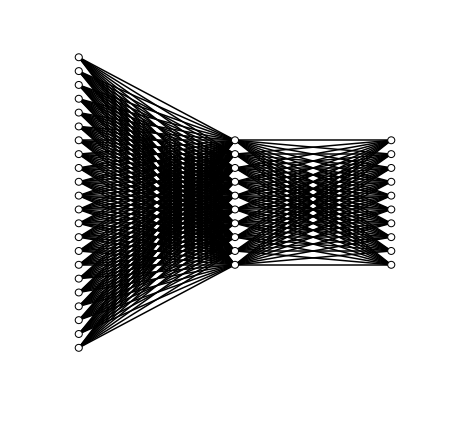

Confusion Matrix:

[[ 32   2   0  10  15   0   0   0   0   6]
 [  1 233   2   0   0   0   0   0   2   2]
 [  0   0  99   0   0   0   3   0   2   0]
 [  0   0   0 114   6   0   0   0   0   0]
 [  1   1   0   3 101   1   0   0   0   0]
 [  1   4   1   0   4  22   0   0   0   0]
 [  0   7   5   1   0   0   9   0   0   0]
 [  0   1   1   6   3   0   0   0   1   0]
 [  1   5   1   2   0   0   0   0  48   0]
 [  1   0   0   0   2   0   0   0   0 677]]


Species,Accuracy,Precision,Recall,F1-score
0,97.36%,86.49%,49.23%,62.75%
1,98.12%,92.09%,97.08%,94.52%
2,98.96%,90.83%,95.19%,92.96%
3,98.05%,83.82%,95.00%,89.06%
4,97.50%,77.10%,94.39%,84.87%
5,99.24%,95.65%,68.75%,80.00%
6,98.89%,75.00%,40.91%,52.94%
7,99.17%,nan%,0.00%,nan%
8,99.03%,90.57%,84.21%,87.27%
9,99.24%,98.83%,99.56%,99.19%


Iteration 3

Hidden Layers,Training Fraction,Number of Steps
[100],80%,100


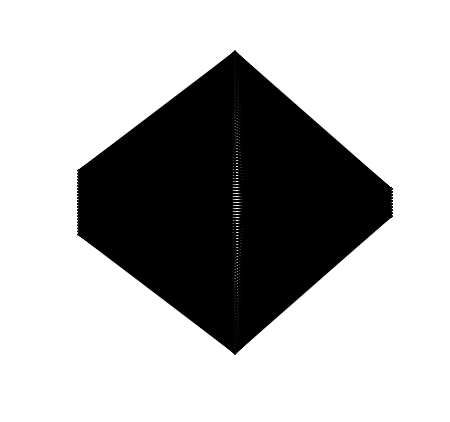

Confusion Matrix:

[[ 33   1   0   7   6   0   0   0   0   7]
 [  1 235   2   0   0   0   0   0   3   0]
 [  0   1  90   1   0   0   3   0   0   0]
 [  1   1   0 126   9   0   2   0   0   0]
 [  3   0   0   0 101   1   0   0   0   0]
 [  3   2   0   0   0  15   1   0   0   0]
 [  0   9   4   0   0   0  16   1   1   0]
 [  0   1   0   0   2   0   0   8   3   0]
 [  0   3   0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0   0   0   0 682]]


Species,Accuracy,Precision,Recall,F1-score
0,97.98%,80.49%,61.11%,69.47%
1,98.33%,92.89%,97.51%,95.14%
2,99.24%,93.75%,94.74%,94.24%
3,98.54%,94.03%,90.65%,92.31%
4,98.54%,85.59%,96.19%,90.58%
5,99.51%,93.75%,71.43%,81.08%
6,98.54%,72.73%,51.61%,60.38%
7,99.51%,88.89%,57.14%,69.57%
8,99.31%,88.52%,94.74%,91.53%
9,99.51%,98.98%,100.00%,99.49%


Iteration 4

Hidden Layers,Training Fraction,Number of Steps
[100],80%,500


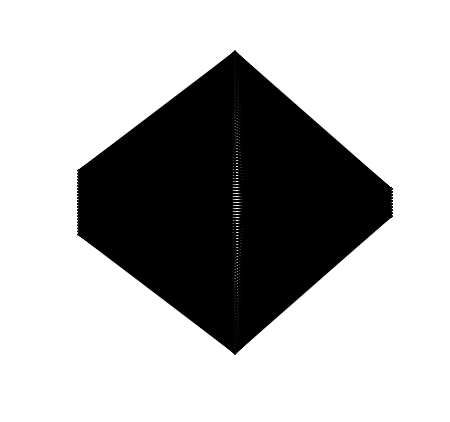

Confusion Matrix:

[[ 47   1   0   6   0   0   0   0   0   3]
 [  1 219   0   0   0   0   1   0   2   2]
 [  0   1  98   0   0   0   0   0   0   0]
 [  2   1   1 123   3   0   2   0   0   0]
 [  2   0   0   2 120   0   0   0   0   0]
 [  0   1   0   0   0  25   0   0   0   0]
 [  0   1   2   0   0   0  13   0   0   0]
 [  0   0   0   1   0   1   0   9   2   0]
 [  1   2   0   1   0   0   0   0  50   0]
 [  0   1   0   0   0   0   0   0   0 692]]


Species,Accuracy,Precision,Recall,F1-score
0,98.89%,88.68%,82.46%,85.45%
1,99.03%,96.48%,97.33%,96.90%
2,99.72%,97.03%,98.99%,98.00%
3,98.68%,92.48%,93.18%,92.83%
4,99.51%,97.56%,96.77%,97.17%
5,99.86%,96.15%,96.15%,96.15%
6,99.58%,81.25%,81.25%,81.25%
7,99.72%,100.00%,69.23%,81.82%
8,99.44%,92.59%,92.59%,92.59%
9,99.58%,99.28%,99.86%,99.57%


Iteration 5

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,100


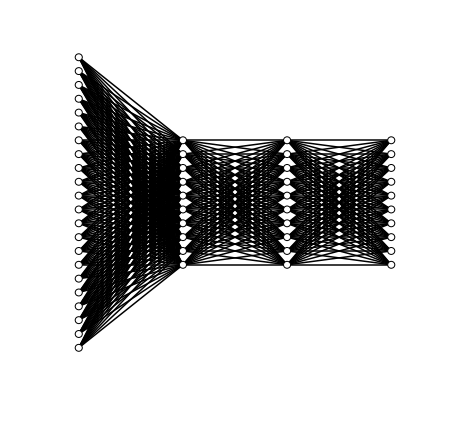

Confusion Matrix:

[[  6  10   0   9  16   0   0   0   0  19]
 [  0 224   5   0   0   0   0   0   0   1]
 [  0   4  88   0   1   0   0   0   0   0]
 [  0   1   0 112  15   0   0   0   0   0]
 [  0   5   0  33  69   0   0   0   0   0]
 [  0  22   2   0   0   0   0   0   0   2]
 [  0  11   5   0   1   0   0   0   0   0]
 [  0   8   0   0   7   0   0   0   0   0]
 [  0  52   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 711]]


Species,Accuracy,Precision,Recall,F1-score
0,96.25%,100.00%,10.00%,18.18%
1,91.73%,66.47%,97.39%,79.01%
2,98.82%,88.00%,94.62%,91.19%
3,95.97%,72.73%,87.50%,79.43%
4,94.58%,63.30%,64.49%,63.89%
5,98.19%,nan%,0.00%,nan%
6,98.82%,nan%,0.00%,nan%
7,98.96%,nan%,0.00%,nan%
8,96.39%,nan%,0.00%,nan%
9,98.47%,97.00%,100.00%,98.48%


Iteration 6

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,500


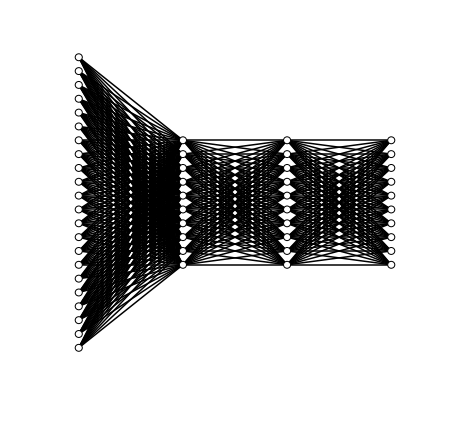

Confusion Matrix:

[[ 41   0   0   4   1   0   0   0   0   8]
 [  0 231   2   0   0   0   0   0   2   0]
 [  0   1  88   1   0   0   2   0   1   0]
 [  1   0   2 124   4   0   1   0   0   0]
 [  1   0   0   2  89   0   0   0   0   0]
 [ 11   1   0   0   0  12   0   0   0   1]
 [  0   3   5   1   0   1  12   0   0   0]
 [  0   1   0   0   0   1   0   7   0   0]
 [  1   1   2   0   0   0   0   0  51   0]
 [  1   1   1   0   0   0   0   0   0 719]]


Species,Accuracy,Precision,Recall,F1-score
0,98.05%,73.21%,75.93%,74.55%
1,99.17%,96.65%,98.30%,97.47%
2,98.82%,88.00%,94.62%,91.19%
3,98.89%,93.94%,93.94%,93.94%
4,99.44%,94.68%,96.74%,95.70%
5,98.96%,85.71%,48.00%,61.54%
6,99.10%,80.00%,54.55%,64.86%
7,99.86%,100.00%,77.78%,87.50%
8,99.51%,94.44%,92.73%,93.58%
9,99.17%,98.76%,99.58%,99.17%


<Figure size 432x288 with 0 Axes>

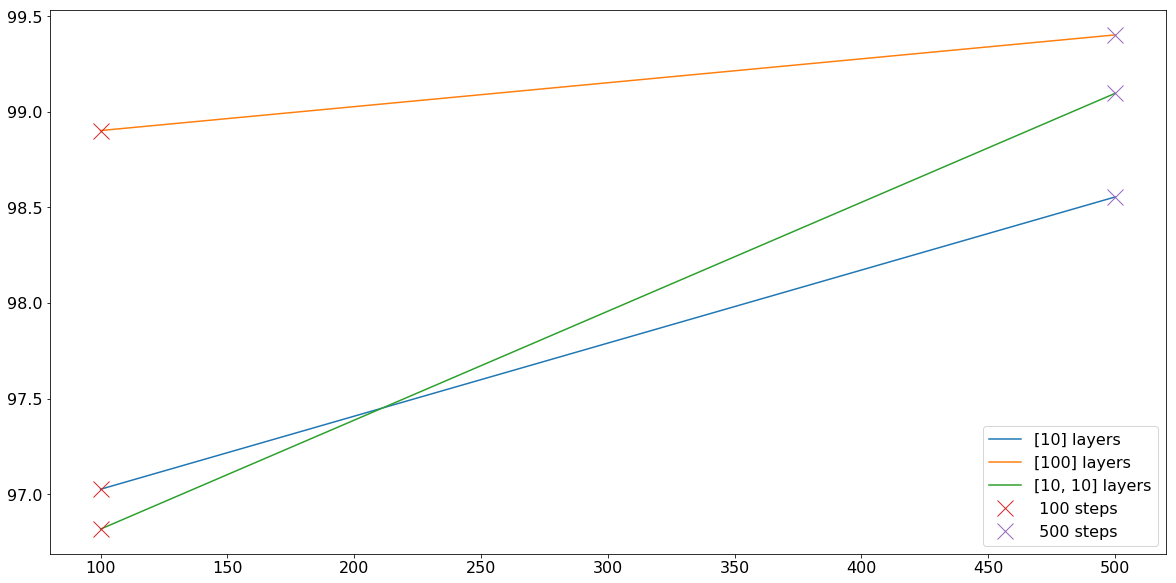

In [65]:
# simple data splitting results
display_model_results(evaluations)

### Cross-Validation approach to dataset splitting
In **k-fold** cross-validation, the original sample is randomly partitioned into k equal size subsamples.

In **stratified k-fold** cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds.

To use one or the other, update the global setting `CROSS_VALIDATION_FUNCTION` in the [Initialize constants](#Initialize-constants) section

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [66]:
# k-fold cross validation
# this may take a while

steps_calc = lambda num_steps, train_fraction: int(num_steps * (1.0 - train_fraction))
# adjustment for k-fold: num_total_model_steps = num_steps * num_folds
kfcv_evaluations = run_model_iterations(df, labels, kFoldCV_tf_data_generator, steps_calc)    


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Ross\\AppData\\Local\\Temp\\tmpplmpma2u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EB212B4E48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Ross\AppData\Local\Temp\tmpplmpma2u\m

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Ross\AppData\Local\Temp\tmpxqfsh5dy\model.ckpt.
INFO:tensorflow:loss = 242.44992, step = 0
INFO:tensorflow:Saving checkpoints for 99 into C:\Users\Ross\AppData\Local\Temp\tmpxqfsh5dy\model.ckpt.
INFO:tensorflow:Loss for final step: 56.82108.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-14:39:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpxqfsh5dy\model.ckpt-99
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-14:39:09
INFO:tensorflow:Saving dict for global step 99: accura

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Ross\AppData\Local\Temp\tmpyvxhamcg\model.ckpt.
INFO:tensorflow:loss = 217.11208, step = 0
INFO:tensorflow:Saving checkpoints for 19 into C:\Users\Ross\AppData\Local\Temp\tmpyvxhamcg\model.ckpt.
INFO:tensorflow:Loss for final step: 49.851658.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-14:39:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpyvxhamcg\model.ckpt-19
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-14:39:25
INFO:tensorflow:Saving dict for global step 19: accuracy = 0.8669439, average_loss = 0.49558672, global_step = 19, loss = 47.67544
INFO:tensorflow:Calling model_fn.
INFO:

INFO:tensorflow:loss = 228.84746, step = 0
INFO:tensorflow:Saving checkpoints for 99 into C:\Users\Ross\AppData\Local\Temp\tmpl7m1tl70\model.ckpt.
INFO:tensorflow:Loss for final step: 23.696365.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-14:39:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpl7m1tl70\model.ckpt-99
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-14:39:39
INFO:tensorflow:Saving dict for global step 99: accuracy = 0.9313929, average_loss = 0.24969028, global_step = 99, loss = 24.020205
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpl7m1tl70\model.ckpt-99
INFO:tensorflow:Running local_init_op.
INFO:tensor

INFO:tensorflow:Loss for final step: 87.05096.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-14:39:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmppbux1av_\model.ckpt-19
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-14:39:56
INFO:tensorflow:Saving dict for global step 19: accuracy = 0.7830908, average_loss = 0.8172419, global_step = 19, loss = 78.61867
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmppbux1av_\model.ckpt-19
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpl99wc4wm\model.ckpt-99
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-14:40:12
INFO:tensorflow:Saving dict for global step 99: accuracy = 0.8905059, average_loss = 0.40902016, global_step = 99, loss = 39.347736
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpl99wc4wm\model.ckpt-99
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ross\AppData\Local\Temp\tmpl99wc4wm\model.ckpt-99
INFO:tensorflow:Running local_init_op.


Model iterations complete

Num Results: 6


Iteration 1

Hidden Layers,Training Fraction,Number of Steps
[10],80%,100


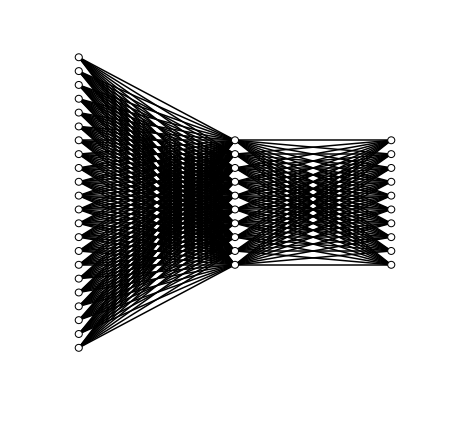

Confusion Matrix:

[[  2  16   0  15  18   0   0   0   0  11]
 [  0 218   3   0   0   0   0   0   1   2]
 [  0  15  77   1   0   0   0   0   1   0]
 [  0   2   1 119  12   0   0   0   0   0]
 [  0   2   0   5 101   0   0   0   0   0]
 [  0  22   3   0   2   0   0   0   0   2]
 [  0  16   4   2   0   0   0   0   0   0]
 [  0   9   2   2   0   0   0   0   0   0]
 [  0  10   0   3   0   0   0   0  41   0]
 [  0   1   0   0   1   0   0   0   0 693]]


Species,Accuracy,Precision,Recall,F1-score
0,95.82%,100.00%,3.23%,6.25%
1,93.10%,70.10%,97.32%,81.50%
2,97.91%,85.56%,81.91%,83.70%
3,97.00%,80.95%,88.81%,84.70%
4,97.21%,75.37%,93.52%,83.47%
5,97.98%,nan%,0.00%,nan%
6,98.47%,nan%,0.00%,nan%
7,99.09%,nan%,0.00%,nan%
8,98.95%,95.35%,75.93%,84.54%
9,98.82%,97.88%,99.71%,98.79%


Iteration 2

Hidden Layers,Training Fraction,Number of Steps
[10],80%,500


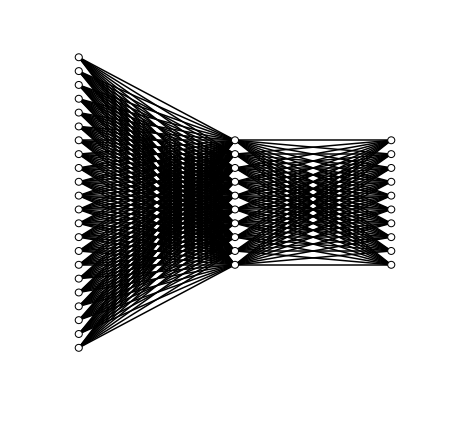

Confusion Matrix:

[[ 38   1   0   9   8   0   0   0   0   6]
 [  0 221   1   0   0   0   0   0   1   1]
 [  0   1  89   1   0   0   2   0   1   0]
 [  0   1   1 127   4   0   1   0   0   0]
 [  4   0   0   4 100   0   0   0   0   0]
 [  1   3   3   0   3  17   1   0   0   1]
 [  0  16   6   0   0   0   0   0   0   0]
 [  0   2   0  10   0   0   0   0   1   0]
 [  0   5   1   0   0   0   1   0  47   0]
 [  1   1   0   0   0   0   0   0   0 693]]


Species,Accuracy,Precision,Recall,F1-score
0,97.91%,86.36%,61.29%,71.70%
1,97.70%,88.05%,98.66%,93.05%
2,98.82%,88.12%,94.68%,91.28%
3,97.84%,84.11%,94.78%,89.12%
4,98.40%,86.96%,92.59%,89.69%
5,99.16%,100.00%,58.62%,73.91%
6,98.12%,0.00%,0.00%,nan%
7,99.09%,nan%,0.00%,nan%
8,99.30%,94.00%,87.04%,90.38%
9,99.30%,98.86%,99.71%,99.28%


Iteration 3

Hidden Layers,Training Fraction,Number of Steps
[100],80%,100


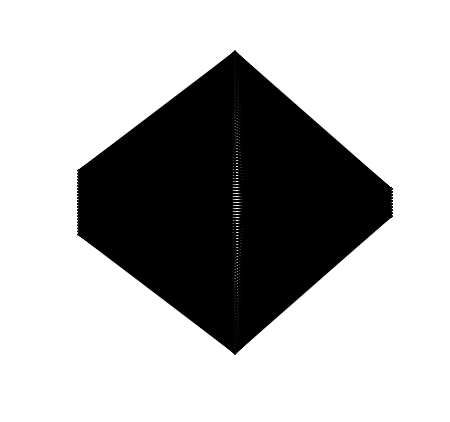

Confusion Matrix:

[[ 39   1   0   8   4   1   0   0   0   9]
 [  0 221   0   0   0   0   1   0   2   0]
 [  0   2  87   0   0   0   5   0   0   0]
 [  0   1   0 127   6   0   0   0   0   0]
 [  4   0   0   0 104   0   0   0   0   0]
 [  3   3   0   0   0  21   2   0   0   0]
 [  0   4   2   0   0   0  16   0   0   0]
 [  0   2   0   0   9   0   1   0   1   0]
 [  0   3   0   0   0   0   1   0  50   0]
 [  1   0   0   0   0   0   1   0   0 693]]


Species,Accuracy,Precision,Recall,F1-score
0,97.84%,82.98%,62.90%,71.56%
1,98.68%,93.25%,98.66%,95.88%
2,99.37%,97.75%,92.55%,95.08%
3,98.95%,94.07%,94.78%,94.42%
4,98.40%,84.55%,96.30%,90.04%
5,99.37%,95.45%,72.41%,82.35%
6,98.82%,59.26%,72.73%,65.31%
7,99.09%,nan%,0.00%,nan%
8,99.51%,94.34%,92.59%,93.46%
9,99.23%,98.72%,99.71%,99.21%


Iteration 4

Hidden Layers,Training Fraction,Number of Steps
[100],80%,500


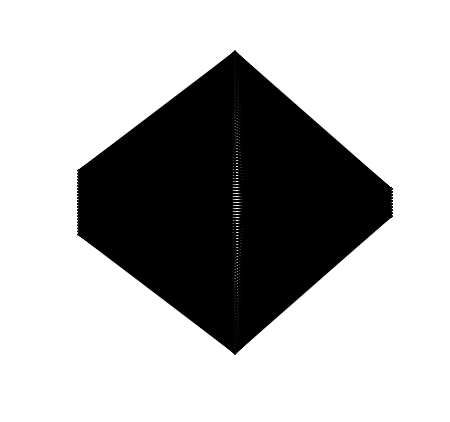

Confusion Matrix:

[[ 51   0   0   5   0   0   0   0   0   6]
 [  0 223   0   0   0   0   0   0   1   0]
 [  0   1  92   0   0   0   1   0   0   0]
 [  1   0   1 130   0   0   2   0   0   0]
 [  0   0   0   2 106   0   0   0   0   0]
 [  0   0   0   0   0  29   0   0   0   0]
 [  0   1   4   0   0   0  17   0   0   0]
 [  1   0   0   0   0   0   0  12   0   0]
 [  0   4   1   0   0   0   0   1  48   0]
 [  1   2   1   0   0   0   0   0   0 691]]


Species,Accuracy,Precision,Recall,F1-score
0,99.02%,94.44%,82.26%,87.93%
1,99.37%,96.54%,99.55%,98.02%
2,99.37%,92.93%,97.87%,95.34%
3,99.23%,94.89%,97.01%,95.94%
4,99.86%,100.00%,98.15%,99.07%
5,100.00%,100.00%,100.00%,100.00%
6,99.44%,85.00%,77.27%,80.95%
7,99.86%,92.31%,92.31%,92.31%
8,99.51%,97.96%,88.89%,93.20%
9,99.30%,99.14%,99.42%,99.28%


Iteration 5

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,100


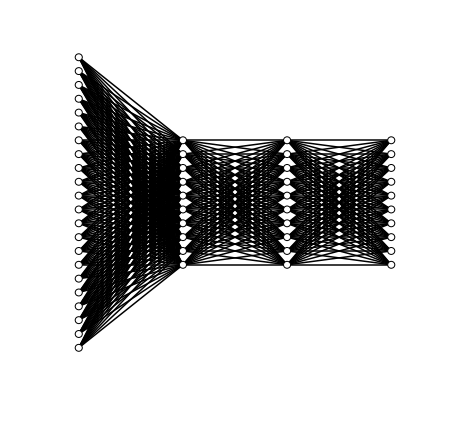

Confusion Matrix:

[[ 21   1   0  16  13   0   0   0   0  11]
 [  0 214   5   1   0   0   0   0   3   1]
 [  0   2  91   0   0   0   0   0   1   0]
 [  0   0   1 127   5   0   0   0   1   0]
 [  2   0   0   4 102   0   0   0   0   0]
 [  8   6   4   1   4   3   0   0   0   3]
 [  0  11   7   1   0   0   0   0   3   0]
 [  0   4   1   2   5   0   0   0   1   0]
 [  0  12   1   2   1   0   0   0  38   0]
 [  2   0   0   0   0   0   0   0   0 693]]


Species,Accuracy,Precision,Recall,F1-score
0,96.31%,63.64%,33.87%,44.21%
1,96.79%,85.60%,95.54%,90.30%
2,98.47%,82.73%,96.81%,89.22%
3,97.63%,82.47%,94.78%,88.19%
4,97.63%,78.46%,94.44%,85.71%
5,98.19%,100.00%,10.34%,18.75%
6,98.47%,nan%,0.00%,nan%
7,99.09%,nan%,0.00%,nan%
8,98.26%,80.85%,70.37%,75.25%
9,98.82%,97.88%,99.71%,98.79%


Iteration 6

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,500


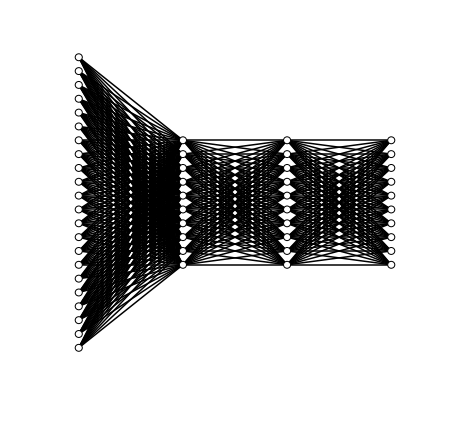

Confusion Matrix:

[[ 39   0   0  12   4   2   0   0   0   5]
 [  0 221   0   0   0   0   1   0   2   0]
 [  0   2  88   0   0   0   3   0   1   0]
 [  2   1   1 128   1   0   1   0   0   0]
 [  5   0   0   0 103   0   0   0   0   0]
 [  8   1   2   0   0  17   0   1   0   0]
 [  0   5   3   0   0   2  12   0   0   0]
 [  0   0   0   6   0   3   0   3   1   0]
 [  0   3   2   0   0   0   2   0  47   0]
 [  2   1   0   0   0   1   0   0   0 691]]


Species,Accuracy,Precision,Recall,F1-score
0,97.21%,69.64%,62.90%,66.10%
1,98.89%,94.44%,98.66%,96.51%
2,99.02%,91.67%,93.62%,92.63%
3,98.33%,87.67%,95.52%,91.43%
4,99.30%,95.37%,95.37%,95.37%
5,98.61%,68.00%,58.62%,62.96%
6,98.82%,63.16%,54.55%,58.54%
7,99.23%,75.00%,23.08%,35.29%
8,99.23%,92.16%,87.04%,89.52%
9,99.37%,99.28%,99.42%,99.35%


<Figure size 432x288 with 0 Axes>

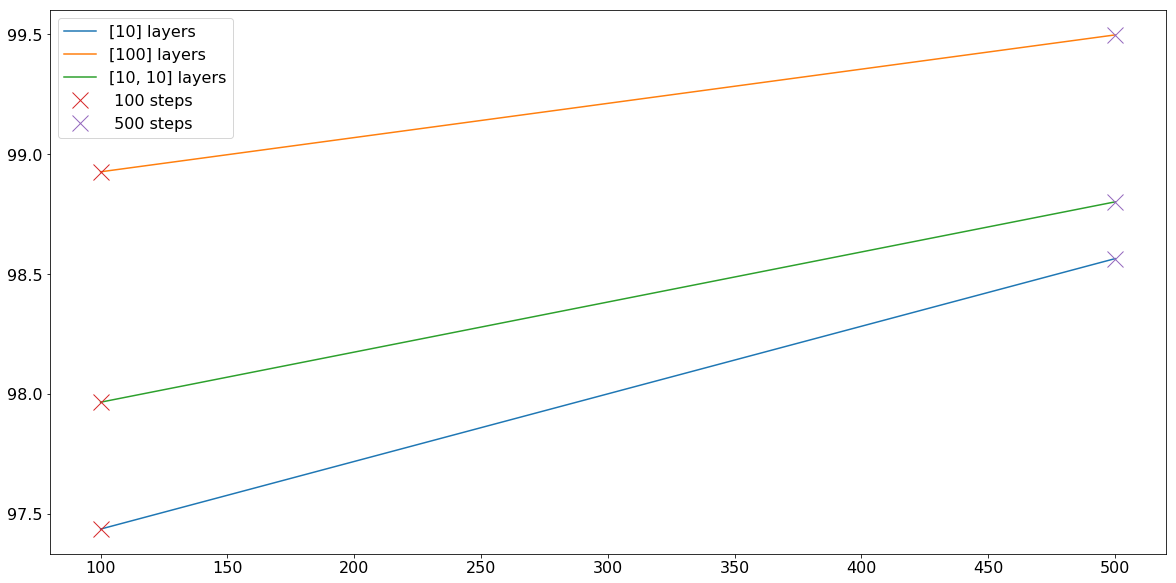

In [67]:
# k-fold Cross-validation data splitting results
display_model_results(kfcv_evaluations)

# Conclusion
The architectural choices of a **Neural Network** are of tremendous importance when designing such a network and its model, including the architecture, the way the data is split and fed into it, the number of times said data goes through the forward and backpropagation mechanisms. 

With our approach we have observed that, for instance, a **Neural Network** with a single layer comprised of 100 nodes, for our dataset, can better describe (without overfitting) the data then a network with two hidden layers of 10 neurons each.

## Other

### Deletes temporary files created by TensorFlow

In [68]:
# Allows deleting models save folder in windows
tf.summary.FileWriterCache.clear()

In [69]:
import tempfile
import os
from pathlib import Path
import shutil

temp_dir = Path(tempfile.gettempdir())
dir_list = [f for f in temp_dir.glob('tmp*') if f.is_dir()] 
for dir in dir_list:
    shutil.rmtree(dir, ignore_errors=True)
        